In [1]:
# load some libraries
import sys
import os
sys.path.insert(1, '..')
os.chdir('..')

import darts
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils.darts_processing import *

# Glucose plots

In [2]:
# plots of uninterpolated glucose data for each patient
formatter, series, scalers = load_data(seed=0, study_file=None, dataset='weinstock', use_covs=True, use_static_covs=True)

--------------------------------
Loading column definition...
Checking column definition...
Loading data...
Dropping columns / rows...
Checking for NA values...
Setting data types...
Dropping columns / rows...
Encoding data...
	Updated column definition:
		id: REAL_VALUED (ID)
		time: DATE (TIME)
		gl: REAL_VALUED (TARGET)
		Height: REAL_VALUED (STATIC_INPUT)
		Weight: REAL_VALUED (STATIC_INPUT)
		Gender: REAL_VALUED (STATIC_INPUT)
		Race: REAL_VALUED (STATIC_INPUT)
		EduLevel: REAL_VALUED (STATIC_INPUT)
		AnnualInc: REAL_VALUED (STATIC_INPUT)
		MaritalStatus: REAL_VALUED (STATIC_INPUT)
		DaysWkEx: REAL_VALUED (STATIC_INPUT)
		DaysWkDrinkAlc: REAL_VALUED (STATIC_INPUT)
		DaysMonBingeAlc: REAL_VALUED (STATIC_INPUT)
		T1DDiagAge: REAL_VALUED (STATIC_INPUT)
		NumHospDKA: REAL_VALUED (STATIC_INPUT)
		NumSHSinceT1DDiag: REAL_VALUED (STATIC_INPUT)
		InsDeliveryMethod: REAL_VALUED (STATIC_INPUT)
		UnitsInsTotal: REAL_VALUED (STATIC_INPUT)
		NumMeterCheckDay: REAL_VALUED (STATIC_INPUT)
		Aspir

In [42]:
# extract data to plot: patients with more than 3 segments
plot_data = []
for pateint_id, patient_data in formatter.data.groupby('id'):
    # count number of unique segments, id_segment
    n_segment = patient_data['id_segment'].nunique()
    if n_segment > 3:
        plot_data.append(patient_data)
        if len(plot_data) == 3:
            break
# for each patient, create a column with number of minutes since the absolute start
#    and convert to long format for plotting
for i, patient_data in enumerate(plot_data):
    patient_data['time'] = patient_data['time'] - patient_data['time'].min()
    # convert time to float, number of hours
    patient_data['time'] = patient_data['time'].dt.total_seconds() / 3600
    # convert to long format for plotting
    plot_data[i] = patient_data.melt(id_vars=['time', 'id_segment'], value_vars=['gl'], var_name='y', value_name='x')


/tmp/ipykernel_110340/2285371106.py:7: UserWarning: The palette list has more values (7) than needed (4), which may not be intended.
  sns.lineplot(x='time', y='x', hue='id_segment',
/tmp/ipykernel_110340/2285371106.py:7: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  sns.lineplot(x='time', y='x', hue='id_segment',
/tmp/ipykernel_110340/2285371106.py:7: UserWarning: The palette list has more values (7) than needed (4), which may not be intended.
  sns.lineplot(x='time', y='x', hue='id_segment',


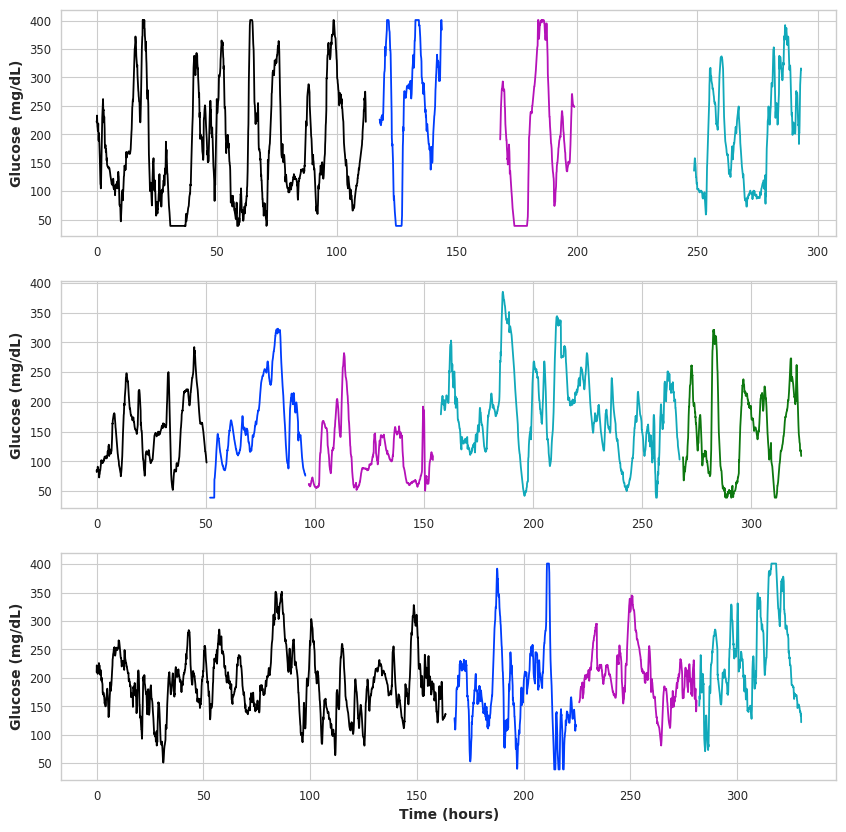

In [54]:
# use whitegrid style
sns.set_style('whitegrid')
colors = ['#000000', '#003DFD', '#b512b8', '#11a9ba', '#0d780f', '#f77f07', '#ba0f0f']
# plot using seaborn
fig, axes = plt.subplots(3, 1, figsize=(10, 10))
for i, patient_data in enumerate(plot_data):
    sns.lineplot(x='time', y='x', hue='id_segment', 
                 data=patient_data, ax=axes[i],
                 palette=colors)
    axes[i].set_ylabel('Glucose (mg/dL)')
    # remove legend
    axes[i].get_legend().remove()
    # only add xlabel to last plot
    axes[i].set_xlabel('')
    if i == 2:
        axes[i].set_xlabel('Time (hours)')
    

# Split and interpolation example plots

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


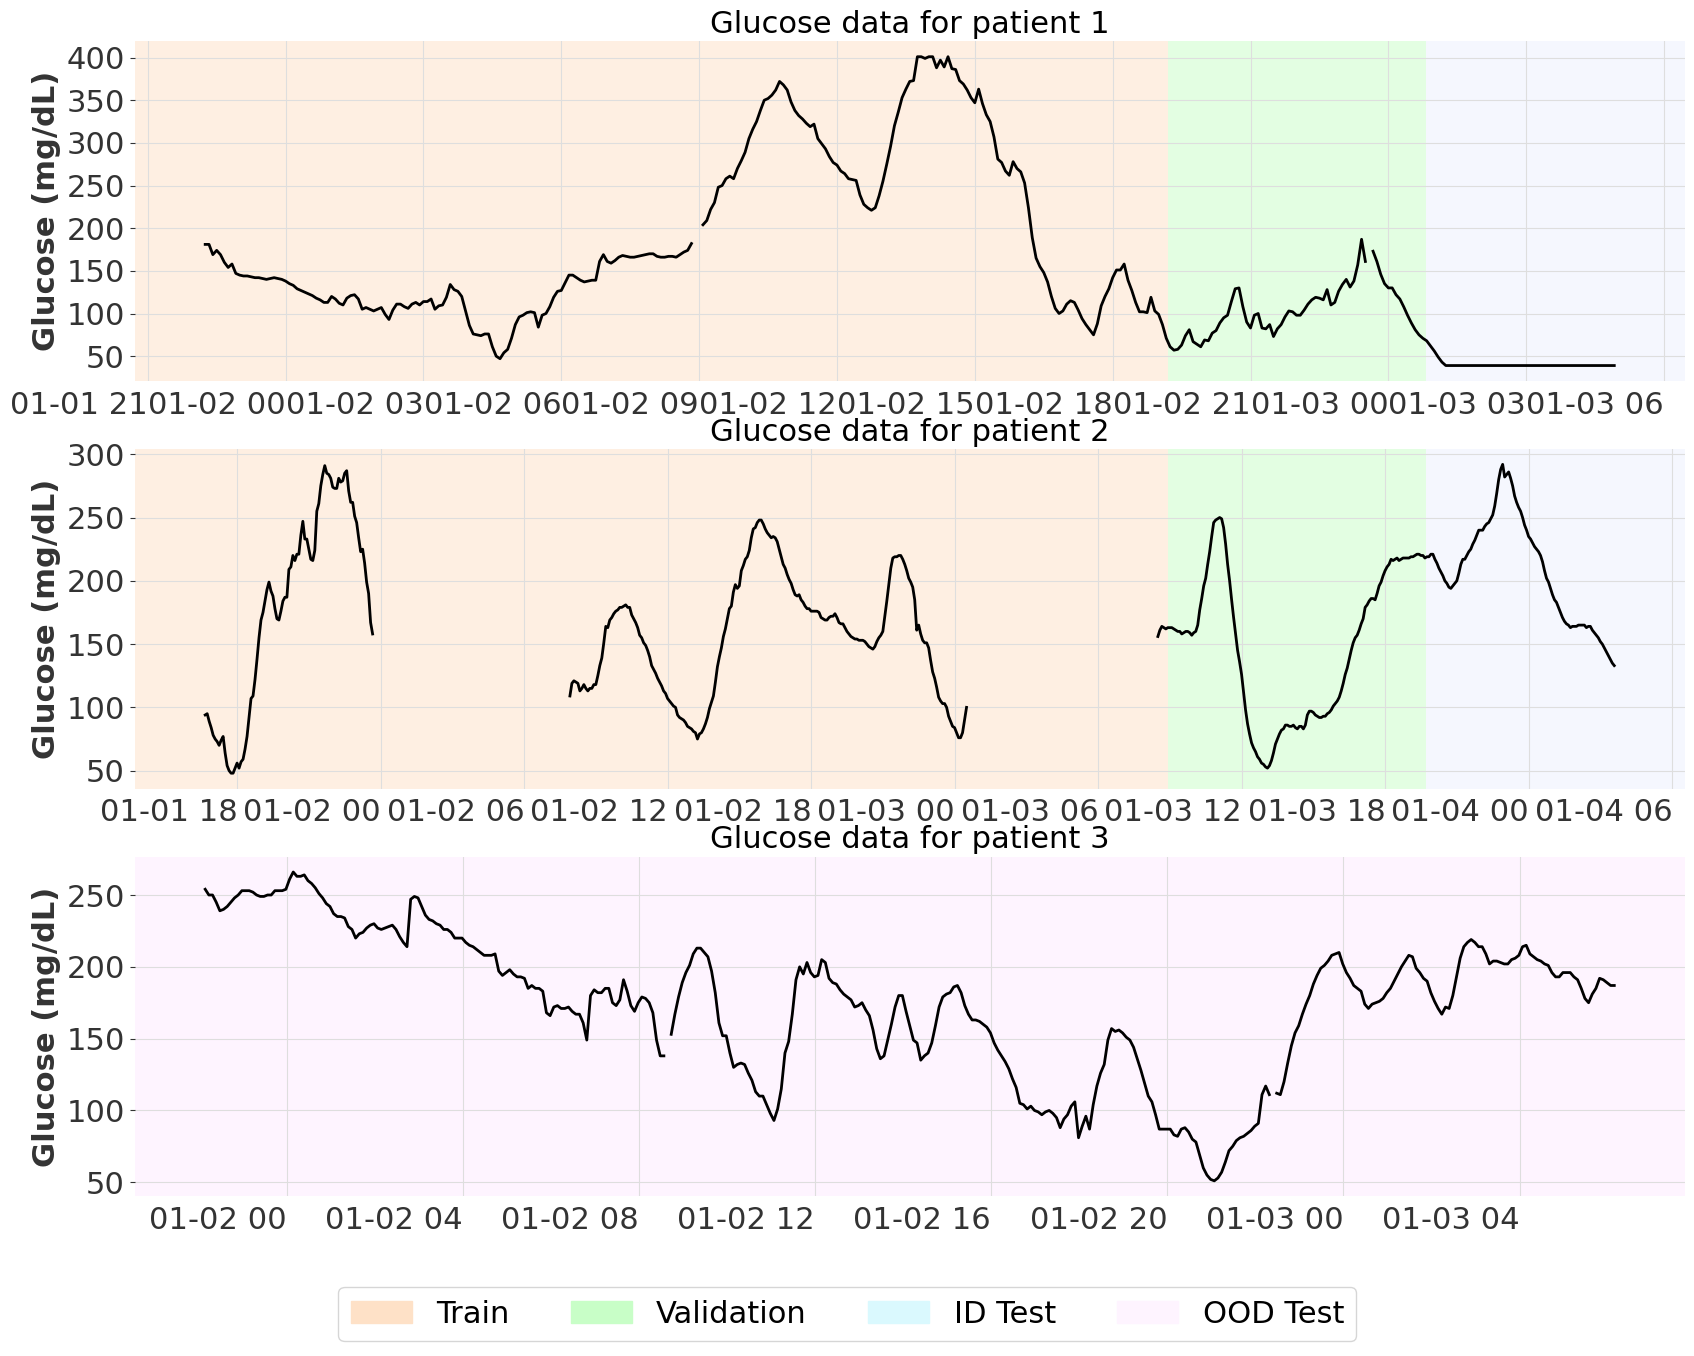

In [11]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# Define the colors for the rectangles
colors = ['#FEE1C7', '#C8FEC7', '#DAF9FE', '#FEF4FF']
labels = ['Train', 'Validation', 'ID Test', 'OOD Test']

# plot glucose data for each id
fig, axs = plt.subplots(3, 1, figsize=(20, 15))
for i, id in enumerate(ids[:3]):
    for j in range(len(id_series[id][:3])):
        id_series[id][j].plot(ax=axs[i], color='black')  # Set the line color to black

    if i < len(ids[:3]) - 1:  # Only create rectangles for the first two plots
        y_min, y_max = axs[i].get_ylim()
        x_min, x_max = axs[i].get_xlim()
        total_width = x_max - x_min
        first_width = total_width * 2/3
        second_width = (total_width - first_width) / 2

        for k, color in enumerate(colors):
            if k == 0:
                width = first_width
            else:
                width = second_width
            rect = Rectangle((x_min + sum(width for width in [first_width, second_width][:k]), y_min),
                             width, y_max - y_min, facecolor=color, alpha=0.5)
            axs[i].add_patch(rect)
    else:  # Set the background color of the last plot to #D6EDFE
        axs[i].set_facecolor('#FEF4FF')

    axs[i].set_ylabel('Glucose (mg/dL)')
    axs[i].set_xlabel('')
    axs[i].set_title(f'Glucose data for patient {i+1}')
    axs[i].tick_params(axis='x', rotation=0)
    if axs[i].get_legend() is not None:
        axs[i].get_legend().remove()
    # increase font size
    for item in ([axs[i].title, axs[i].xaxis.label, axs[i].yaxis.label] +
                axs[i].get_xticklabels() + axs[i].get_yticklabels()):
        item.set_fontsize(22)

# Create a custom legend for the colors
legend_elements = [Rectangle((0, 0), 1, 1, facecolor=color, edgecolor=color, label=label)
                   for color, label in zip(colors, labels)]
fig.legend(handles=legend_elements, loc='lower center', ncol=len(colors), fontsize=22, frameon=True)

# save as pdf with transparent background
plt.savefig('presentation/plots/glucose_data_split_plot.pdf', bbox_inches='tight', transparent=False)


# Example plots of other Timeseries

In [6]:
# load electrcity data 
from darts.datasets import TemperatureDataset
from darts.datasets import AirPassengersDataset
from darts.datasets import HeartRateDataset

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


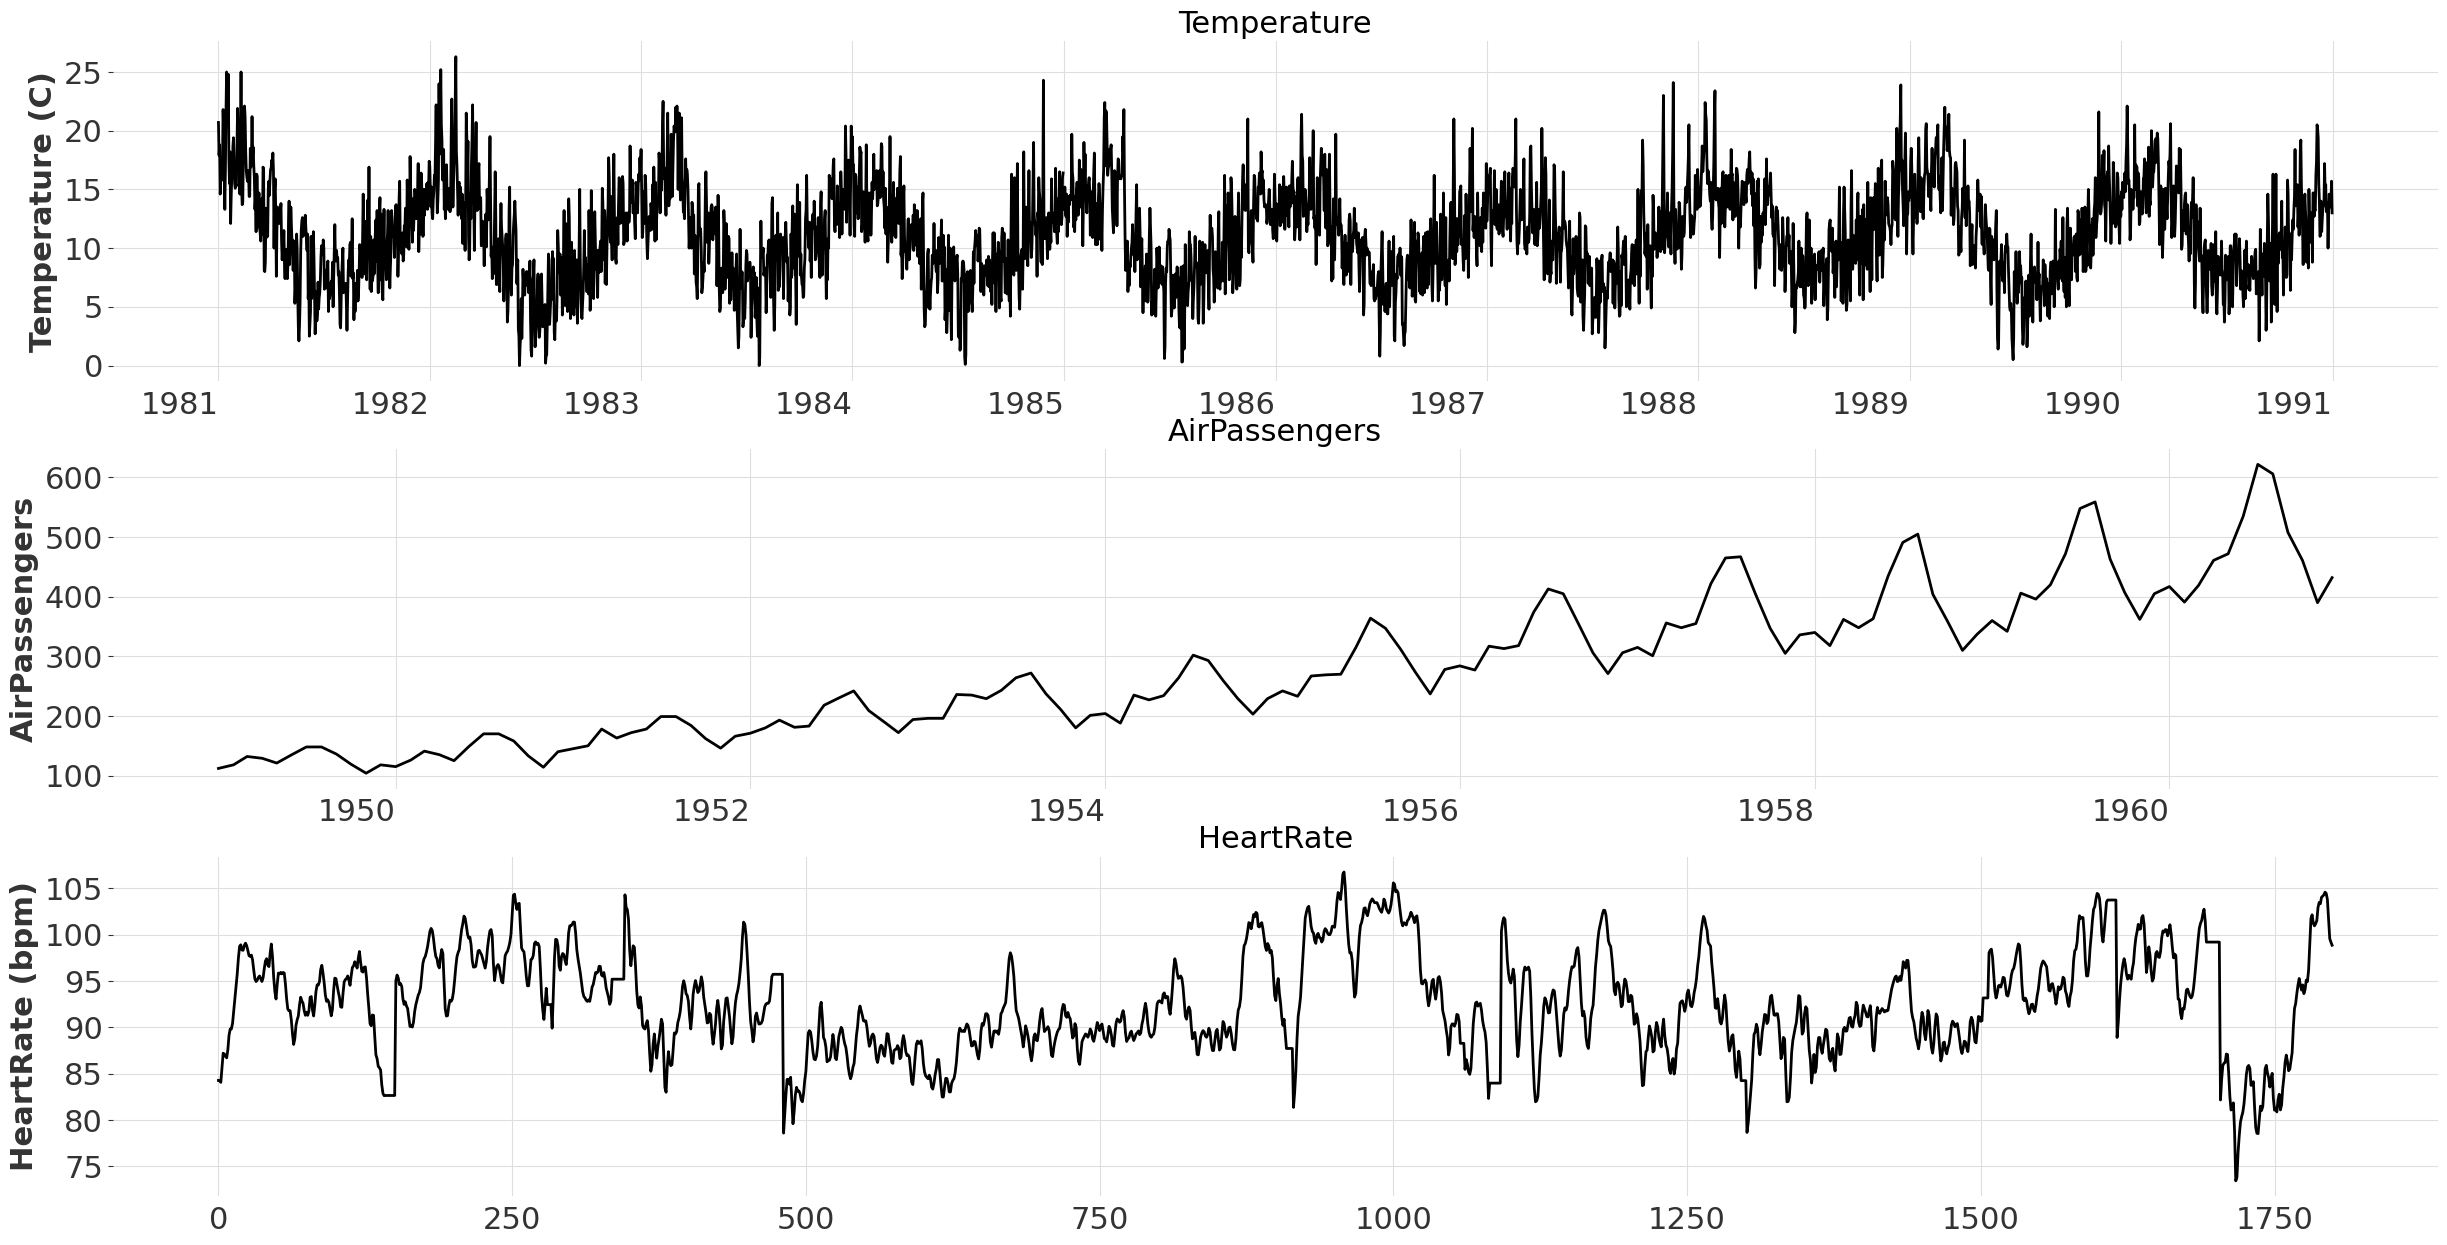

In [7]:
fig, axs = plt.subplots(3, 1, figsize=(30, 15))
dataset_names = ['Temperature', 'AirPassengers', 'HeartRate']
yaxis = ['Temperature (C)', 'AirPassengers', 'HeartRate (bpm)']
for i, dataset in enumerate([TemperatureDataset(), AirPassengersDataset(), HeartRateDataset()]):
    dataset.load().plot(ax=axs[i])
    axs[i].set_ylabel(f'{yaxis[i]}')
    axs[i].set_xlabel('')
    axs[i].tick_params(axis='x', rotation=0)
    axs[i].set_title(f'{dataset_names[i]}')
    if axs[i].get_legend() is not None:
        axs[i].get_legend().remove()
    # increase font size
    for item in ([axs[i].title, axs[i].xaxis.label, axs[i].yaxis.label] +
                axs[i].get_xticklabels() + axs[i].get_yticklabels()):
        item.set_fontsize(22)
# save as pdf
plt.savefig('presentation/plots/ts_data.pdf', bbox_inches='tight')

# Day and night error distribution: linear regression

In [2]:
# load data
dataset_name = 'weinstock'
use_covs = False
use_static_covs = False
cov_type = 'past'
formatter, series, scalers = load_data(seed=0, study_file=None, dataset='weinstock', 
                                       use_covs=use_covs, use_static_covs=use_static_covs,
                                       cov_type=cov_type)

--------------------------------
Loading column definition...
Checking column definition...
Loading data...
Dropping columns / rows...
Checking for NA values...
Setting data types...
Dropping columns / rows...
Encoding data...
	Updated column definition:
		id: REAL_VALUED (ID)
		time: DATE (TIME)
		gl: REAL_VALUED (TARGET)
		Height: REAL_VALUED (STATIC_INPUT)
		Weight: REAL_VALUED (STATIC_INPUT)
		Gender: REAL_VALUED (STATIC_INPUT)
		Race: REAL_VALUED (STATIC_INPUT)
		EduLevel: REAL_VALUED (STATIC_INPUT)
		AnnualInc: REAL_VALUED (STATIC_INPUT)
		MaritalStatus: REAL_VALUED (STATIC_INPUT)
		DaysWkEx: REAL_VALUED (STATIC_INPUT)
		DaysWkDrinkAlc: REAL_VALUED (STATIC_INPUT)
		DaysMonBingeAlc: REAL_VALUED (STATIC_INPUT)
		T1DDiagAge: REAL_VALUED (STATIC_INPUT)
		NumHospDKA: REAL_VALUED (STATIC_INPUT)
		NumSHSinceT1DDiag: REAL_VALUED (STATIC_INPUT)
		InsDeliveryMethod: REAL_VALUED (STATIC_INPUT)
		UnitsInsTotal: REAL_VALUED (STATIC_INPUT)
		NumMeterCheckDay: REAL_VALUED (STATIC_INPUT)
		Aspir

In [70]:
# load model: regression
model = models.LinearRegressionModel(lags = formatter.params['linreg']['in_len'],
                                     output_chunk_length = formatter.params['length_pred'])
model.fit(series['train']['target'])
# get predictions
forecasts = model.historical_forecasts(series['test']['target'],
                                       past_covariates = series['test']['dynamic'],
                                       future_covariates = series['test']['future'],
                                       forecast_horizon=formatter.params['length_pred'], 
                                       stride=formatter.params['length_pred'],
                                       retrain=False,
                                       verbose=False,
                                       last_points_only=False,
                                       start=formatter.params["max_length_input"])
forecasts = [forecast for forecast in forecasts]
# unscale predictions and targets
forecasts = [scalers['target'].inverse_transform(forecast) for forecast in forecasts]
series['test']['target'] = scalers['target'].inverse_transform(series['test']['target'])

In [71]:
from darts import metrics
# divide forecasts into day / night and compute MSE error
day_errors, night_errors = [], []
for i, forecast_segment in enumerate(forecasts):
    for forecast in forecast_segment:
        # get first point timestamp
        start_time = forecast.start_time()
        # get hour of day
        hour = start_time.hour
        if hour >= 6 and hour <= 22:
            day_errors.append(np.sqrt(metrics.mse(forecast, series['test']['target'][i])))
        else:
            night_errors.append(np.sqrt(metrics.mse(forecast, series['test']['target'][i])))

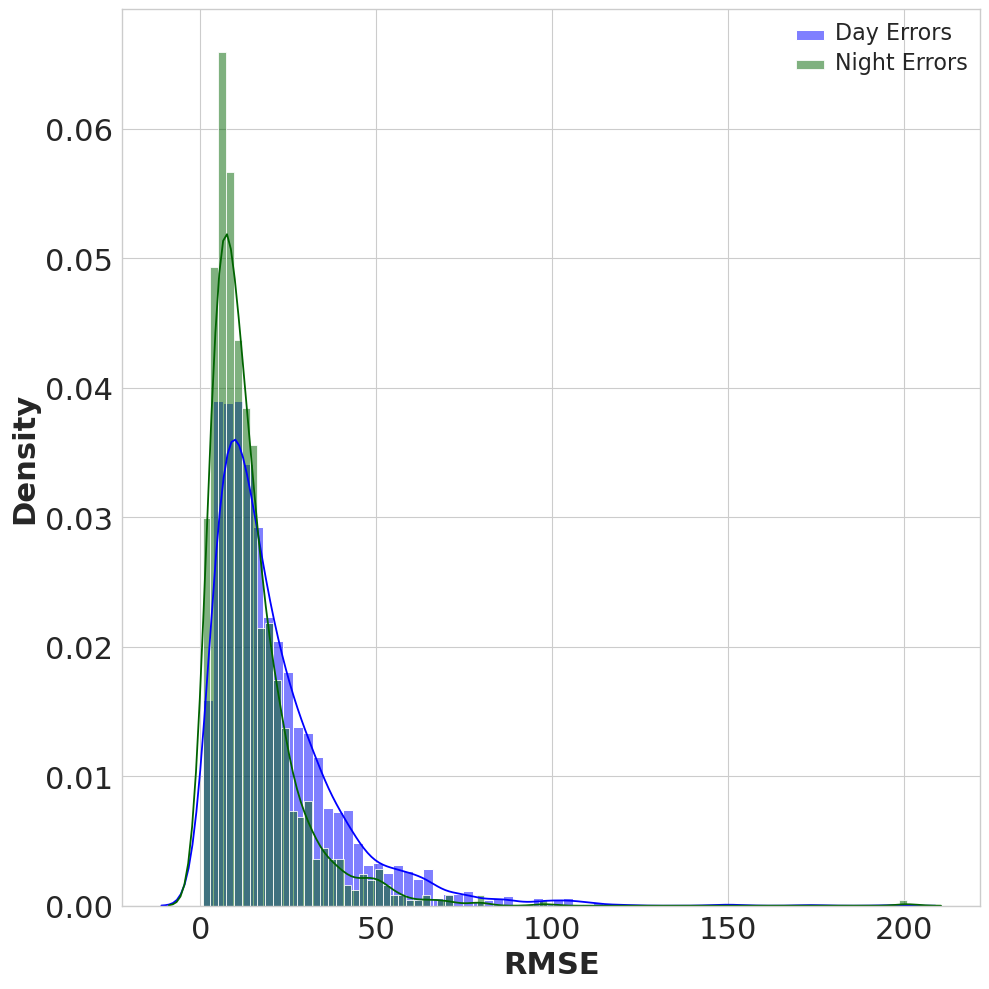

In [82]:
# plot density and normalized histogram of day / night errors
fig, ax = plt.subplots(figsize=(10, 10))
# plot normalized histogram
sns.histplot(day_errors, stat='density', alpha=0.5, color='blue', label='Day Errors', ax=ax)
sns.histplot(night_errors, stat='density', alpha=0.5, color='darkgreen', label='Night Errors', ax=ax)
# Plot density estimates of the two lists of values
sns.kdeplot(day_errors, color='blue', linestyle='-', ax=ax)
sns.kdeplot(night_errors, color='darkgreen', linestyle='-', ax=ax)
# Add legend
ax.legend()
# set x and y labels
ax.set_xlabel('RMSE')
ax.set_ylabel('Density')
# add legend
ax.legend()
# increase font size of x and y labels, title and legend
for item in ([ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(22)
for item in ax.get_legend().get_texts():
        item.set_fontsize(16)
# save as pdf
plt.tight_layout()
plt.savefig("./presentation/plots/night_vs_day_error_linreg_weinstock.pdf")

# Day and night error distribution: transformer

In [ ]:
# load data
dataset_name = 'weinstock'
use_covs = False
use_static_covs = False
cov_type = 'past'
formatter, series, scalers = load_data(seed=0, study_file=None, dataset='weinstock', 
                                       use_covs=use_covs, use_static_covs=use_static_covs,
                                       cov_type=cov_type)

In [85]:
# load model: transformer
model = models.TransformerModel(input_chunk_length=formatter.params['transformer']['in_len'],
                                output_chunk_length=formatter.params['length_pred'], 
                                d_model=formatter.params['transformer']['d_model'], 
                                nhead=formatter.params['transformer']['n_heads'],
                                num_encoder_layers=formatter.params['transformer']['num_encoder_layers'],
                                num_decoder_layers=formatter.params['transformer']['num_decoder_layers'],
                                dim_feedforward=formatter.params['transformer']['dim_feedforward'],
                                dropout=formatter.params['transformer']['dropout'])
model.load_from_checkpoint('tensorboard_transformer_weinstock', work_dir = './output')
# get predictions
test_dataset = SamplingDatasetInferencePast(target_series=series['test']['target'],
                                                        covariates=series['test']['dynamic'],
                                                        n=out_len,
                                                        input_chunk_length=in_len,
                                                        output_chunk_length=out_len,
                                                        use_static_covariates=False,
                                                        max_samples_per_ts = None)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/grads/m/mrsergazinov/.conda/envs/glunet/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=4)`.
  rank_zero_warn(

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 256   
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer         | Transformer         | 764 K 
6 | decoder             | Linear              | 1.5 K 
------------------------------------------------------------
766 K     Trainable par

Training: 0it [00:00, ?it/s]

/home/grads/m/mrsergazinov/.conda/envs/glunet/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/grads/m/mrsergazinov/.conda/envs/glunet/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=4)`.
  rank_zero_warn(

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0 

Training: 0it [00:00, ?it/s]

# Gluformer test results

In [2]:
# plots of uninterpolated glucose data for each patient
formatter, series, scalers = load_data(seed=0, study_file=None, dataset='weinstock', use_covs=True, use_static_covs=True)

--------------------------------
Loading column definition...
Checking column definition...
Loading data...
Dropping columns / rows...
Checking for NA values...
Setting data types...
Dropping columns / rows...
Encoding data...
	Updated column definition:
		id: REAL_VALUED (ID)
		time: DATE (TIME)
		gl: REAL_VALUED (TARGET)
		Height: REAL_VALUED (STATIC_INPUT)
		Weight: REAL_VALUED (STATIC_INPUT)
		Gender: REAL_VALUED (STATIC_INPUT)
		Race: REAL_VALUED (STATIC_INPUT)
		EduLevel: REAL_VALUED (STATIC_INPUT)
		AnnualInc: REAL_VALUED (STATIC_INPUT)
		MaritalStatus: REAL_VALUED (STATIC_INPUT)
		DaysWkEx: REAL_VALUED (STATIC_INPUT)
		DaysWkDrinkAlc: REAL_VALUED (STATIC_INPUT)
		DaysMonBingeAlc: REAL_VALUED (STATIC_INPUT)
		T1DDiagAge: REAL_VALUED (STATIC_INPUT)
		NumHospDKA: REAL_VALUED (STATIC_INPUT)
		NumSHSinceT1DDiag: REAL_VALUED (STATIC_INPUT)
		InsDeliveryMethod: REAL_VALUED (STATIC_INPUT)
		UnitsInsTotal: REAL_VALUED (STATIC_INPUT)
		NumMeterCheckDay: REAL_VALUED (STATIC_INPUT)
		Aspir

In [4]:
from utils.darts_dataset import SamplingDatasetDual, SamplingDatasetInferenceDual

dataset_test = SamplingDatasetInferenceDual(target_series=series['test']['target'],
                                            covariates=series['test']['future'],
                                            input_chunk_length=in_len,
                                            output_chunk_length=out_len,
                                            use_static_covariates=True,
                                            array_output_only=True)

In [5]:
import torch
from lib.gluformer.model import Gluformer

model = Gluformer(d_model = d_model, 
                n_heads = n_heads, 
                d_fcn = d_fcn, 
                r_drop = 0.2, 
                activ = 'relu', 
                num_enc_layers = num_enc_layers, 
                num_dec_layers = num_dec_layers,
                distil = True, 
                len_seq = in_len,
                label_len = label_len,
                len_pred = out_len,
                num_dynamic_features = num_dynamic_features,
                num_static_features = num_static_features,)

# load model
model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda')))

<All keys matched successfully>

In [6]:
predictions, logvar = model.predict(dataset_test,
                                    batch_size=3,
                                    num_samples=20,
                                    device='cuda',)

In [7]:
# get inputs and targets
trues = np.array([dataset_test.evalsample(i).values() for i in range(len(dataset_test))])
inputs = np.array([dataset_test[i][0] for i in range(len(dataset_test))])

In [8]:
# scale all
inputs = (inputs - scalers['target'].min_) / scalers['target'].scale_
trues = (trues - scalers['target'].min_) / scalers['target'].scale_
predictions = (predictions - scalers['target'].min_) / scalers['target'].scale_
var = np.exp(logvar) / scalers['target'].scale_**2

In [9]:
predictions.shape

(46691, 12, 20)

In [10]:
samples = np.random.normal(loc=predictions[..., None],
                            scale=np.sqrt(np.exp(logvar))[..., None],
                            size=(predictions.shape[0], 
                                    predictions.shape[1], 
                                    predictions.shape[2],
                                    30))
samples = samples.reshape(samples.shape[0], samples.shape[1], -1)

In [17]:
# define the color gradient
import matplotlib.colors as mcolors
import seaborn as sns
colors = ['#00264c', '#0a2c62', '#14437f', '#1f5a9d', '#2973bb', '#358ad9', '#4d9af4', '#7bb7ff', '#add5ff', '#e6f3ff']
cmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
# set matplotlib theme to seaborn whitegrid
sns.set_theme(style="whitegrid")

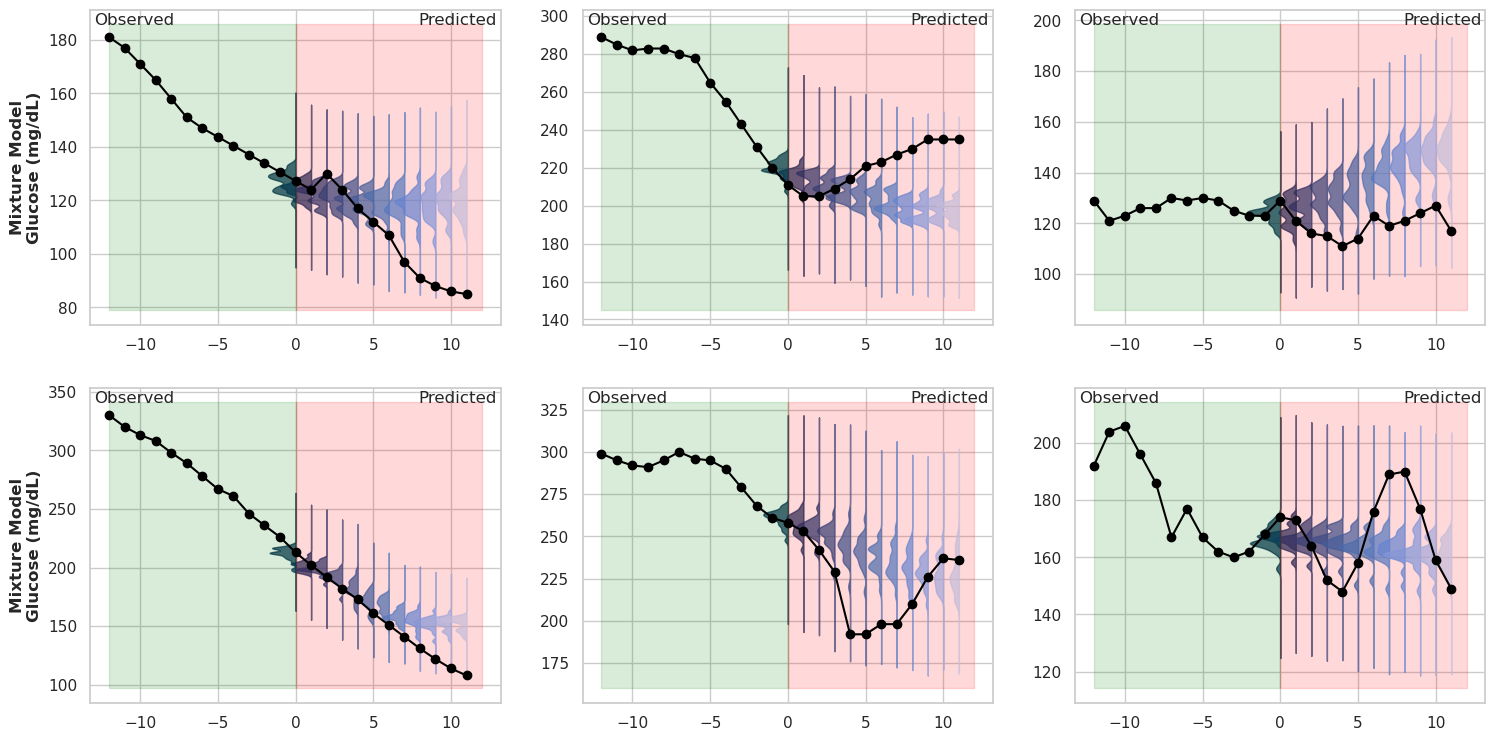

In [40]:
# plot
plot_samples = [100, 1100, 2500, 3000, 4000, 10000]
fig, axs = plt.subplots(2, 3, figsize=(18, 9))

for ind in range(6):
        ax = axs[ind // 3, ind % 3]
        # if plot number == 0 or 3, add y-label
        if ind % 3 == 0:
                ax.set_ylabel('Mixture Model\nGlucose (mg/dL)')
        # select sample to plot
        ind = plot_samples[ind]
        for point in range(samples.shape[1]):
                kde = stats.gaussian_kde(samples[ind, point, :])
                maxi, mini = 1.2 * np.max(samples[ind, point, :]), 0.8 * np.min(samples[ind, point, :])
                y_grid = np.linspace(mini, maxi, 200)
                x = kde(y_grid)
                ax.fill_betweenx(y_grid, x1 = point, x2 = point - x * 15, 
                                alpha=0.7, 
                                edgecolor='black',
                                color=cmap(point / samples.shape[1]))
        # plot true value
        ax.plot(np.arange(-12, 12), 
                np.concatenate([inputs[ind, -12:, 0], trues[ind, :, 0]]), 
                label='input', 
                color='black', 
                marker='o')
        # deliniate observed and predicted part
        abs_min, abs_max = ax.get_ylim()
        ax.fill_betweenx([abs_min, abs_max], x1 = -12, x2 = 0, color='green', alpha=0.15)
        ax.fill_betweenx([abs_min, abs_max], x1 = 0, x2 = 12, color='red', alpha=0.15)
        ax.text(.01, .99, 'Observed', ha='left', va='top', transform=ax.transAxes)
        ax.text(.99, .99, 'Predicted', ha='right', va='top', transform=ax.transAxes)
# save figure
plt.savefig('./presentation/plots/gluformer_prediction.pdf', bbox_inches='tight')